In [1]:
%load_ext autoreload
%autoreload 2

## Creating Audio File

Checkout https://beta.elevenlabs.io/history for full log of audio creation

In [2]:
file_name = "./kitten_full"
mp3_file_name = file_name + ".mp3"
wav_file_name = file_name + ".wav"

generate_new_audio = False
name_of_voice = "Bella"
text = "I love you"

In [3]:
# Get voice ID
import requests

r1 = requests.get('https://api.elevenlabs.io/v1/voices')
resp = r1.json()
rid = ""
for voice in resp["voices"]:
    if voice["name"] == name_of_voice:
        print(voice)
        rid = voice["voice_id"]
        break;
rid

{'voice_id': 'EXAVITQu4vr4xnSDxMaL', 'name': 'Bella', 'samples': None, 'category': 'premade', 'fine_tuning': {'is_allowed_to_fine_tune': False, 'fine_tuning_requested': False, 'finetuning_state': 'not_started', 'verification_attempts': None, 'verification_attempts_count': 0}, 'labels': {}, 'preview_url': 'https://storage.googleapis.com/eleven-public-prod/premade/voices/EXAVITQu4vr4xnSDxMaL/04365bce-98cc-4e99-9f10-56b60680cda9.mp3', 'available_for_tiers': [], 'settings': None}


'EXAVITQu4vr4xnSDxMaL'

In [4]:
# Get audio file, minimize runs cost money
import json

if generate_new_audio:
    url = "https://api.elevenlabs.io/v1/text-to-speech/{voice_id}".format(voice_id=rid)
    print(url)
    headers = {'xi-api-key': "aa42307ce6bfbefcfd2abd4d8634127b"}
    payload = {
      "text": text,
      "voice_settings": {
        "stability": 0.3,
        "similarity_boost": 0.75
      }
    }

    r2 = requests.post(url, data=json.dumps(payload), headers=headers)
    print(r2)

In [5]:
# Save and play audio file
import os

if generate_new_audio:
    with open(mp3_file_name, 'wb') as f:
        f.write(r2.content)

    os.system("mpg123 " + mp3_file_name)

In [6]:
# convert mp3 to wav                                                            
from pydub import AudioSegment
from pydub.playback import play

if generate_new_audio:
    sound = AudioSegment.from_mp3(mp3_file_name)
    sound.export(wav_file_name, format="wav")

    # test sound
    song = AudioSegment.from_wav(wav_file_name)
    play(song)

## Generate phonemes
- Uses https://github.com/m-bain/whisperX

In [7]:
# no extension, must be wav
import os
cwd = os.getcwd() #pwd
print(cwd)

audio_file_name = wav_file_name
base_audio_file_name = os.path.basename(audio_file_name)
print("File name:", audio_file_name)
print("Base name:", base_audio_file_name)

/home/paperspace/repos/infinitenews/ForcedAlignment
File name: ./kitten_full.wav
Base name: kitten_full.wav


In [8]:
import gc
import torch
import whisperx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transcribe with original whisper
model = whisperx.load_model("large", device)
# model = whisperx.load_model("base.en", device)

In [9]:
result = model.transcribe(audio_file_name)
print(result["segments"]) # before alignment

[{'id': 0, 'seek': 0, 'start': 0.0, 'end': 1.4000000000000001, 'text': ' Good evening, everyone.', 'tokens': [2205, 5634, 11, 1518, 13], 'temperature': 0.0, 'avg_logprob': -0.29579041067477874, 'compression_ratio': 1.6071428571428572, 'no_speech_prob': 0.0020821006037294865}, {'id': 1, 'seek': 0, 'start': 1.4000000000000001, 'end': 5.96, 'text': ' Sidney Scott here bringing you the latest news from the upside down world.', 'tokens': [19797, 2397, 6659, 510, 5062, 291, 264, 6792, 2583, 490, 264, 14119, 760, 1002, 13], 'temperature': 0.0, 'avg_logprob': -0.29579041067477874, 'compression_ratio': 1.6071428571428572, 'no_speech_prob': 0.0020821006037294865}, {'id': 2, 'seek': 0, 'start': 5.96, 'end': 11.0, 'text': ' It appears that Ponzi schemes, once thought to be a financial fraud tool used', 'tokens': [467, 7038, 300, 31756, 3992, 26954, 11, 1564, 1194, 281, 312, 257, 4669, 14560, 2290, 1143], 'temperature': 0.0, 'avg_logprob': -0.29579041067477874, 'compression_ratio': 1.60714285714285

In [10]:
# load alignment model and metadata
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)

# align whisper output
result_aligned = whisperx.align(result["segments"], model_a, metadata, audio_file_name, device)

# print(result_aligned["segments"]) # after alignment
result_aligned["word_segments"]

[{'text': 'Good', 'start': 0.10144927536231885, 'end': 0.24347826086956526},
 {'text': 'evening,', 'start': 0.30434782608695654, 'end': 0.5478260869565218},
 {'text': 'everyone.', 'start': 0.6086956521739131, 'end': 0.9942028985507247},
 {'text': 'Sidney', 'start': 1.5205286343612336, 'end': 1.8218502202643172},
 {'text': 'Scott', 'start': 1.8620264317180617, 'end': 2.20352422907489},
 {'text': 'here', 'start': 2.2437004405286345, 'end': 2.4244933920704845},
 {'text': 'bringing', 'start': 2.4847577092511015, 'end': 2.786079295154185},
 {'text': 'you', 'start': 2.8262555066079296, 'end': 2.946784140969163},
 {'text': 'the', 'start': 3.0070484581497796, 'end': 3.0874008810572686},
 {'text': 'latest', 'start': 3.127577092511013, 'end': 3.4489867841409687},
 {'text': 'news', 'start': 3.5293392070484577, 'end': 3.7503083700440527},
 {'text': 'from', 'start': 3.8105726872246697, 'end': 3.9511894273127757},
 {'text': 'the', 'start': 3.9712775330396477, 'end': 4.071718061674009},
 {'text': 'up

In [11]:
test_words = ["that's", "Help! ", "multiverse", "cat", "permit", "surprise", ",whales"]

In [12]:
import nltk

try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

In [13]:
import re
from functools import lru_cache
from itertools import product as iterprod

def cleanWord(word):
    regex = r"[^\w\']"
    return re.sub(regex, "", word).lower()

def arpabetWithoutNumbers(word):
    list_of_phones = []
    for phones in arpabet[word]:
        new_phones = ["".join(filter(lambda x: x.isalpha(), phone)) for phone in phones]
        list_of_phones.append(new_phones)
    return list_of_phones

def wordbreak(s):
    s = cleanWord(s)
    if s in arpabet:
        return arpabetWithoutNumbers(s)
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabetWithoutNumbers(pre), wordbreak(suf))]
    return None

# Example words: 
for w in test_words:
    print(wordbreak(w))

[['DH', 'AE', 'T', 'S']]
[['HH', 'EH', 'L', 'P']]
[['M', 'AH', 'L', 'T', 'IY', 'V', 'ER', 'S']]
[['K', 'AE', 'T']]
[['P', 'ER', 'M', 'IH', 'T'], ['P', 'ER', 'M', 'IH', 'T']]
[['S', 'ER', 'P', 'R', 'AY', 'Z'], ['S', 'AH', 'P', 'R', 'AY', 'Z']]
[['W', 'EY', 'L', 'Z'], ['HH', 'W', 'EY', 'L', 'Z']]


In [14]:
def letterToPhone(word, phones):
    # print("LTP", word, phones)
    if word == "":
        return []

    for i in reversed(range(1, len(word))):
        for j in range(0, len(word) - i + 1):
            subword = word[j:i+j]
            cur_possible_phones = wordbreak(subword)
            #For when has contractions
            if not cur_possible_phones:
#                 print("Skipping", i, j, subword, cur_possible_phones)
                continue
            else:
                cur_possible_phones = cur_possible_phones + [[subword.upper()]]
#                 print(i, j, subword, cur_possible_phones)

            for cur_phones in cur_possible_phones:
                extra_length = len(phones) - len(cur_phones)
#                 print("EL", extra_length)
                if extra_length > 0:
                    for a in range(0, extra_length + 1):
                        subphones_end = len(phones) - (extra_length - a)
                        subphones = phones[a:subphones_end]
                        if len(subphones) != len(cur_phones):
                            print("Lengths not equal....")
                        #print(subphones, cur_phones)
                        if subphones == cur_phones:
                            #print("MATCH", subword, subphones)
                            first = letterToPhone(word[0:j], phones[0:a])
                            cur = letterToPhone(subword, subphones)
                            last = letterToPhone(word[i+j:], phones[subphones_end:])
                            # print("LTP Complete", first, cur, last)
                            return first + cur + last
                    
    return [[word.upper(), phones]]

for segment in result_aligned["word_segments"]:
    word = segment["text"]
# for word in test_words:
#     print(word)
#     print(letterToPhone(word, wordbreak(word)[0]))
#     print([word, wordbreak(word)[0]], "\n")

In [15]:
chunked_words = []
for segment in result_aligned["word_segments"]:
    word = segment["text"]
    chunked_words.append(letterToPhone(word, wordbreak(word)[0]))

In [16]:
chunked_words[0]

[['G', ['G']], ['OO', ['UH']], ['D', ['D']]]

# Parsing out the transcriptions

In [17]:
ts = [o['text'] for o in result_aligned["word_segments"]]

In [18]:
ts = '|'.join(ts).upper()
ts = ts.replace(',', '')
ts = ts.replace('.', '')

In [19]:
ts

"GOOD|EVENING|EVERYONE|SIDNEY|SCOTT|HERE|BRINGING|YOU|THE|LATEST|NEWS|FROM|THE|UPSIDE|DOWN|WORLD|IT|APPEARS|THAT|PONZI|SCHEMES|ONCE|THOUGHT|TO|BE|A|FINANCIAL|FRAUD|TOOL|USED|ONLY|BY|HUMANS|HAVE|NOW|JUMPED|SPECIES|AND|KITTENS|CAN|NOW|APPARENTLY|BE|USED|TO|SCAM|PEOPLE|OUT|OF|THEIR|HARD-EARNED|MONEY|THE|SCHEME|WORKS|LIKE|ANY|OTHER|PONZI|SCHEME|WITH|THE|CATS|BEING|SOLD|FOR|A|LARGE|SUM|OF|MONEY|AND|THEN|BREEDING|MORE|CATS|TO|SELL|FOR|EVEN|MORE|ALL|TOO|OFTEN|THE|CATS|ARE|SOLD|FOR|MORE|MONEY|THAN|WHAT|THEY|ARE|ACTUALLY|WORTH|RESULTING|IN|A|HUGE|PROFIT|FOR|THE|SELLER|AND|A|HUGE|LOSS|FOR|THE|BUYER|THE|PROBLEM|IS|THAT|THESE|CATS|WHILE|CUTE|AND|CUDDLY|ARE|NOT|WORTH|THEIR|HEFTY|PRICE|TAGS|AND|ARE|NOT|EVEN|CLOSE|TO|BEING|A|TRUE|INVESTMENT|UNFORTUNATELY|THIS|NEW|FORM|OF|SCAM|HAS|BEEN|CAUSING|A|LOT|OF|FINANCIAL|ISSUES|AND|HEARTACHE|FOR|PEOPLE|IN|THE|UPSIDE-DOWN|WORLD|BUT|LUCKILY|THE|AUTHORITIES|HAVE|BEEN|CRACKING|DOWN|ON|THESE|SCHEMES|IN|AN|EFFORT|TO|PROTECT|PEOPLE'S|FINANCIAL|WELL-BEING|I'D|SUGGEST|

# FORCED ALIGNMENT FROM WAV2VEC2

In [20]:
import os
from dataclasses import dataclass

import torch
import torchaudio

import IPython
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

In [21]:
# model we are loading
MODEL_NAME = 'WAV2VEC2_ASR_LARGE_LV60K_960H'
# MODEL_NAME = 'WAV2VEC2_ASR_BASE_960H'
# MODEL_NAME = 'WAV2VEC2_ASR_LARGE_960H'
# sampling rate the model expects
# NOTE: most wav2vec models assume 16k sampling rate
MODEL_SR = 16_000


@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5f}, {self.end:5f})"

    @property
    def length(self):
        return self.end - self.start



def load_audio(wav_file, model_sr=MODEL_SR):
    '''Loads `wav_file` using torchaudio.
    
    Resamples the audio to `MODEL_SR` if needed.
    '''
    wav, sr = torchaudio.load(wav_file)
    if sr != model_sr:
        print(f'Resampling from {sr} to {MODEL_SR}')
        wav = torchaudio.transforms.Resample(sr, MODEL_SR)(wav)
    return wav


def clean_text(o):
    clean = o.replace(',', ' ')
    clean = clean.strip('\n')
    return clean

def load_transcript(text_file):
    '''Loads a transcript in `text_file`.
    
    Assumes one transcription per line.
    '''
    # load text file
    lines = open(text_file, encoding="utf8").readlines()
    # cleanup the text
    lines = [clean_text(line) for line in lines]
    # replace spaces with special token `|`
    lines = ['|'.join(line.split(' ')) for line in lines]
    # make all characters upper-case for wav2vec token outputs
    lines = [line.upper() for line in lines]
    return lines
    
    
def load_model(model_name):
    '''Loads a pytorch `model_name` from torchaudio.
    '''
    bundle = getattr(torchaudio.pipelines, model_name, None)
    if bundle:
        model = bundle.get_model()
    else:
        raise ValueError(f'Could not find model: {model_name}')
    return model, bundle



def get_emissions(model, audio):
    '''Gets token probabilities from `model` for the speech given in `audio`.
    '''
    emissions, _ = model(audio)
    emissions = torch.log_softmax(emissions, dim=-1)
    return emissions


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


def merge_repeats(path, transcript):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words

In [22]:
# example run through


def run_forced_alignment(
    model_name,
    speech_file,
    text_file,
    device=None,
    
):
    
    # set the hardware device
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load the model
    model, bundle = load_model(model_name)
    model.eval()
    model.to(device)

    # get model labels
    labels = bundle.get_labels()
    dictionary = {c: i for i, c in enumerate(labels)}
    print(f'Aligning wav2vec2 tokens:')
    print('\n'.join([f'{k}: {v}' for k,v in dictionary.items()]))

    # load the audio and transcript
    audio = load_audio(speech_file)
    audio = audio.to(device)
    print(f'Audio shape: {audio.shape}')
    
    # read in the transcript
    if os.path.isfile(text_file):
        transcript = load_transcript(text_file)[0]
    else:
        print(f'Note: using "{text_file}" as the transcript')
        transcript = text_file
        
    # turn the transcript into tokens
    tokens = [dictionary[c] for c in transcript]

    # get the token probabilities
    emissions = get_emissions(model, audio)
    emissions = emissions[0].detach().cpu()

    # populate the trellis
    trellis = get_trellis(emissions, tokens)

    # walkback to find the most likely trellis path
    path = backtrack(trellis, emissions, tokens)

    # merge the paths with repeated labels
    segments = merge_repeats(path, transcript)

    # merge the words based on the separator token '|'
    word_segments = merge_words(segments)
    
    # cleanup the model
    del model
    model = None
    torch.cuda.empty_cache()
    gc.collect()
    
    return {
        'character_segs': segments,
        'word_segs': word_segments,
        'trellis': trellis,
        'emissions': emissions,
        'tokens': tokens,
        'path': path,
        'audio': audio,
        'bundle': bundle,
    }

### Cleaning up some GPU memory

In [23]:
!nvidia-smi

Sun Mar  5 05:39:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0  On |                  Off |
| 41%   52C    P2    48W / 140W |  11236MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
del model
model = None
torch.cuda.empty_cache()
gc.collect() 

del model_a
model_a = None
torch.cuda.empty_cache()
gc.collect() 

0

In [25]:
!nvidia-smi

Sun Mar  5 05:39:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0  On |                  Off |
| 41%   53C    P2    46W / 140W |   1496MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Calling the Force Alignment on the `kitten_full.wav` file

In [26]:
speech_file = 'kitten_full.wav'
text_file = ts
model_name = MODEL_NAME


segs = run_forced_alignment(
    model_name,
    speech_file,
    text_file,
    device='cpu',
)

Aligning wav2vec2 tokens:
-: 0
|: 1
E: 2
T: 3
A: 4
O: 5
N: 6
I: 7
H: 8
S: 9
R: 10
D: 11
L: 12
U: 13
M: 14
W: 15
C: 16
F: 17
G: 18
Y: 19
P: 20
B: 21
V: 22
K: 23
': 24
X: 25
J: 26
Q: 27
Z: 28
Resampling from 22050 to 16000
Audio shape: torch.Size([1, 1271014])
Note: using "GOOD|EVENING|EVERYONE|SIDNEY|SCOTT|HERE|BRINGING|YOU|THE|LATEST|NEWS|FROM|THE|UPSIDE|DOWN|WORLD|IT|APPEARS|THAT|PONZI|SCHEMES|ONCE|THOUGHT|TO|BE|A|FINANCIAL|FRAUD|TOOL|USED|ONLY|BY|HUMANS|HAVE|NOW|JUMPED|SPECIES|AND|KITTENS|CAN|NOW|APPARENTLY|BE|USED|TO|SCAM|PEOPLE|OUT|OF|THEIR|HARD-EARNED|MONEY|THE|SCHEME|WORKS|LIKE|ANY|OTHER|PONZI|SCHEME|WITH|THE|CATS|BEING|SOLD|FOR|A|LARGE|SUM|OF|MONEY|AND|THEN|BREEDING|MORE|CATS|TO|SELL|FOR|EVEN|MORE|ALL|TOO|OFTEN|THE|CATS|ARE|SOLD|FOR|MORE|MONEY|THAN|WHAT|THEY|ARE|ACTUALLY|WORTH|RESULTING|IN|A|HUGE|PROFIT|FOR|THE|SELLER|AND|A|HUGE|LOSS|FOR|THE|BUYER|THE|PROBLEM|IS|THAT|THESE|CATS|WHILE|CUTE|AND|CUDDLY|ARE|NOT|WORTH|THEIR|HEFTY|PRICE|TAGS|AND|ARE|NOT|EVEN|CLOSE|TO|BEING|A|TRUE|INVE

In [27]:
# character segmentation map
segs['character_segs']

[G	(1.00): [5.000000, 6.000000),
 O	(1.00): [6.000000, 9.000000),
 O	(1.00): [9.000000, 10.000000),
 D	(0.96): [10.000000, 12.000000),
 |	(1.00): [12.000000, 15.000000),
 E	(1.00): [15.000000, 17.000000),
 V	(1.00): [17.000000, 18.000000),
 E	(0.95): [18.000000, 21.000000),
 N	(1.00): [21.000000, 23.000000),
 I	(1.00): [23.000000, 24.000000),
 N	(1.00): [24.000000, 26.000000),
 G	(1.00): [26.000000, 27.000000),
 |	(1.00): [27.000000, 29.000000),
 E	(1.00): [29.000000, 31.000000),
 V	(0.97): [31.000000, 33.000000),
 E	(1.00): [33.000000, 34.000000),
 R	(1.00): [34.000000, 36.000000),
 Y	(0.91): [36.000000, 47.000000),
 O	(1.00): [47.000000, 48.000000),
 N	(0.80): [48.000000, 50.000000),
 E	(0.99): [50.000000, 51.000000),
 |	(0.96): [51.000000, 76.000000),
 S	(1.00): [76.000000, 79.000000),
 I	(0.79): [79.000000, 81.000000),
 D	(1.00): [81.000000, 84.000000),
 N	(1.00): [84.000000, 86.000000),
 E	(0.60): [86.000000, 88.000000),
 Y	(0.99): [88.000000, 90.000000),
 |	(0.42): [90.000000, 93

In [28]:
# view a few chunked words
chunked_words[2]

[['E', ['EH']],
 ['V', ['V']],
 ['E', ['IY']],
 ['RY', []],
 ['O', ['W', 'AH']],
 ['N', ['N']],
 ['E.', []]]

# HERE: MAPPING CHARACTER DURATIONS TO PHONES

In [29]:

# make a copy of the wav2vec2 character segments, to be safe
char_segs = segs['character_segs'][:]
# this pointer will align character segments with words
char_ptr = 0

# stores the info for the needed transcriptions
full_info = []


def frame_to_ms(frame):
    '''Converts a wav2vec2 frame index into miliseconds.
    '''
    return int(frame * 1000 / 50) # * 20 <-- miliseconds/frame


# number of frames to pad around phonemes
pad_beg = 10
pad_end = 8

# step through the chunked, phoneme words
for cword in chunked_words:

    # phone alignments for this word
    alns = []
    
    # cleanup punctuation from the current word
    word = ''.join(o[0] for o in cword).lower()
    word = word.replace(',', '')
    word = word.replace('.', '')
    
    
    # step through the pairs of letters/phones for this word
    for (letters, phones) in cword:
        
        # cleanup punctuation from the letters
        if letters:
            letters = letters.replace(',', '')
            letters = letters.replace('.', '')
        
        # group the character segments for this letter/phone pair
        cur_segs = []
        while ''.join(o.label for o in cur_segs) != letters and char_ptr < len(char_segs):
            cur_segs.append(char_segs[char_ptr])
            char_ptr += 1
             
        # add precise phone timestamps
        if phones:
            
            if cur_segs:
                # start and stop time of this current segment
                beg_ms = cur_beg = frame_to_ms(cur_segs[0].start)
                end_ms = frame_to_ms(cur_segs[-1].end)

                # find the duration of each phone
                dur = end_ms - beg_ms
                dur_per_phone = dur / len(phones)
                
                # if there is more than one phone, the duration is spread equally
                # else, the entire segment duration is allocated to the single phone
                for idx,phone in enumerate(phones):
                    cur_end = cur_beg + dur_per_phone
                    if cur_segs:
                        alns.append({
                            'ph': phone,
                            'bg': int(cur_beg - pad_beg),
                            'ed': int(cur_end + pad_end),
                        })
                    cur_beg = cur_end
                
                
        # if no phones are given for this letter, then extend the previous phone's durations   
        else:
            # make sure we have phones and segments for coverage
            if alns and cur_segs:
                # extend the interval
                prev_seg = alns[-1]
                prev_seg['ed'] = frame_to_ms(cur_segs[-1].end)
                alns[-1] = prev_seg
                
        
    # add the info we phone timestamp info for this word
    full_info.append({
        'word': word,
        'phones': alns
    })
            
        
    # check if we still have segments to process
    if char_ptr < len(char_segs):
        
        # if we're at the end of a word, add a silence
        if char_segs[char_ptr].label == '|':
            char_ptr += 1
            full_info.append({
                'word': 'SIL',
                'phones': [{
                    'ph': 'sil',
                    'bg': full_info[-1]['phones'][-1]['ed'],
                    'ed': frame_to_ms(char_segs[char_ptr].start),
                }],
            })


In [30]:
full_info


[{'word': 'good',
  'phones': [{'ph': 'G', 'bg': 90, 'ed': 128},
   {'ph': 'UH', 'bg': 110, 'ed': 208},
   {'ph': 'D', 'bg': 190, 'ed': 248}]},
 {'word': 'SIL', 'phones': [{'ph': 'sil', 'bg': 248, 'ed': 300}]},
 {'word': 'evening',
  'phones': [{'ph': 'IY', 'bg': 290, 'ed': 348},
   {'ph': 'V', 'bg': 330, 'ed': 428},
   {'ph': 'N', 'bg': 410, 'ed': 468},
   {'ph': 'IH', 'bg': 450, 'ed': 488},
   {'ph': 'NG', 'bg': 470, 'ed': 548}]},
 {'word': 'SIL', 'phones': [{'ph': 'sil', 'bg': 548, 'ed': 580}]},
 {'word': 'everyone',
  'phones': [{'ph': 'EH', 'bg': 570, 'ed': 628},
   {'ph': 'V', 'bg': 610, 'ed': 668},
   {'ph': 'IY', 'bg': 650, 'ed': 940},
   {'ph': 'W', 'bg': 930, 'ed': 958},
   {'ph': 'AH', 'bg': 940, 'ed': 968},
   {'ph': 'N', 'bg': 950, 'ed': 1020}]},
 {'word': 'SIL', 'phones': [{'ph': 'sil', 'bg': 1020, 'ed': 1520}]},
 {'word': 'sidney',
  'phones': [{'ph': 'S', 'bg': 1510, 'ed': 1588},
   {'ph': 'IH', 'bg': 1570, 'ed': 1628},
   {'ph': 'D', 'bg': 1610, 'ed': 1688},
   {'ph': 

# Trying to plot the segments

In [31]:
trellis, segments, word_segments, waveform, bundle = segs['trellis'], segs['character_segs'], segs['word_segs'], segs['audio'], segs['bundle']

In [32]:
def plot_alignments(trellis, segments, word_segments, waveform, bundle):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))

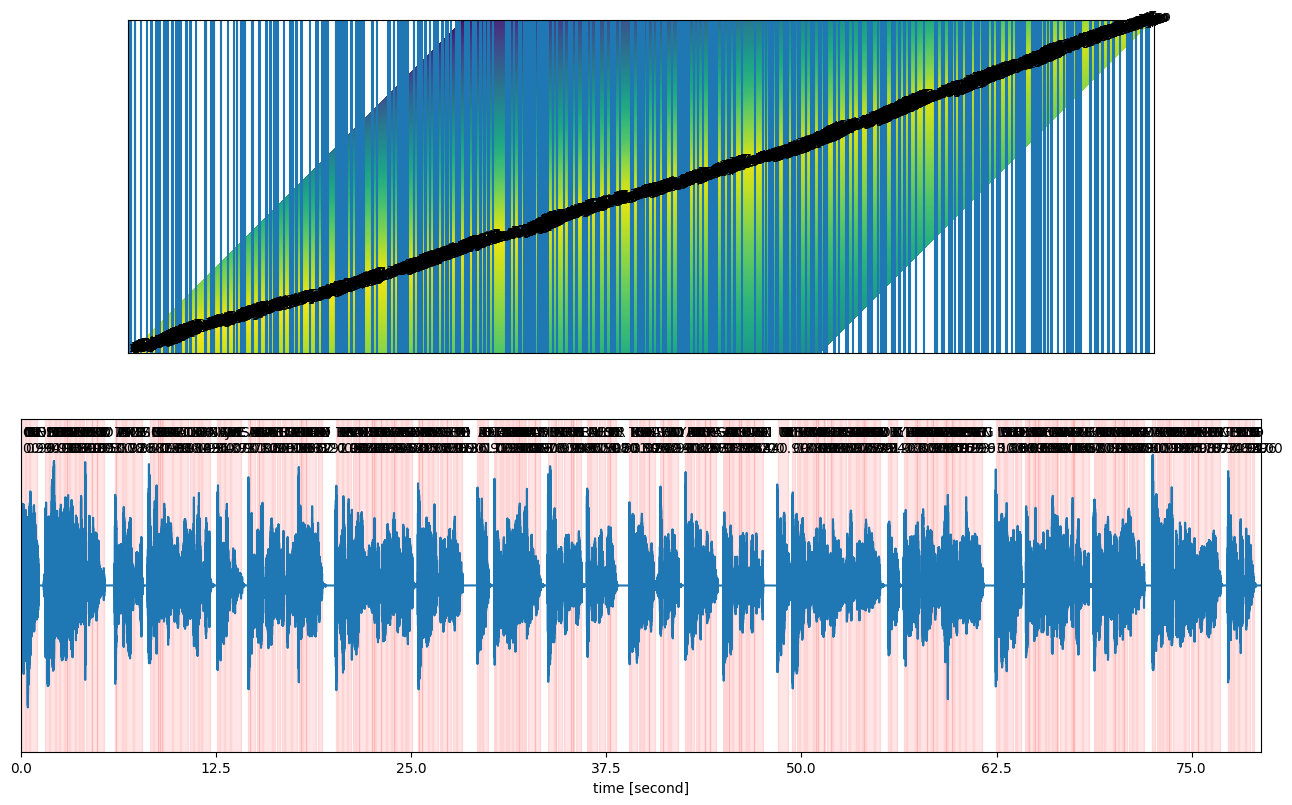

In [33]:
plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
    bundle,
)
plt.show()

In [34]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(bundle, trellis, word_segments, i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)

In [35]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_phone(bundle, trellis, all_phones, seg_idx, phone_idx):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    phones = all_phones[seg_idx]
    phone = phones['phones'][phone_idx]
    x0 = int(ratio * (phone['bg'] / 20))
    x1 = int(ratio * (phone['ed'] / 20))
    print(f"{phone['ph']}: {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)

In [36]:
def display_helper(i):
    return display_segment(bundle, trellis, word_segments, i)

In [37]:
display_phone(bundle, trellis, full_info, 0, 0)

G: 0.090 - 0.128 sec


In [38]:
display_phone(bundle, trellis, full_info, 0, 1)

UH: 0.110 - 0.208 sec


In [39]:
display_phone(bundle, trellis, full_info, 0, 2)

D: 0.190 - 0.248 sec


In [52]:
display_phone(bundle, trellis, full_info, 2, 0)

IY: 0.290 - 0.348 sec


In [53]:
display_phone(bundle, trellis, full_info, 2, 1)

V: 0.330 - 0.428 sec


In [54]:
display_phone(bundle, trellis, full_info, 2, 2)

N: 0.410 - 0.468 sec


In [55]:
full_info[0]

{'word': 'good',
 'phones': [{'ph': 'G', 'bg': 90, 'ed': 128},
  {'ph': 'UH', 'bg': 110, 'ed': 208},
  {'ph': 'D', 'bg': 190, 'ed': 248}]}

In [56]:
display_helper(0)

GOOD (0.99): 0.100 - 0.240 sec


In [57]:
display_helper(1)

EVENING (0.99): 0.300 - 0.540 sec


In [58]:
display_helper(2)

EVERYONE (0.94): 0.580 - 1.020 sec


In [59]:
display_helper(3)

SIDNEY (0.91): 1.520 - 1.800 sec


In [60]:
display_helper(4)

SCOTT (0.93): 1.860 - 2.200 sec


In [61]:
display_helper(-1)

OFF (1.00): 78.878 - 78.998 sec


In [ ]:
display_helper(-2)

### Group into needed format

In [49]:
import pandas as pd

In [50]:
segs['character_segs'][-3]

O	(1.00): [3943.000000, 3945.000000)

In [51]:
phone_align

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_4110/2920447252.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_4110/2920447252.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'phone_align' is not defined

In [ ]:
s

In [ ]:
[(o.start / 50, o.end / 50) for o in segs['word_segs']]

# Comparing the alignments

In [ ]:
result_aligned["word_segments"];

### NODE: older code below

In [ ]:
# {'text': 'Good', 'start': 0.10120481927710842, 'end': 0.32385542168674697},
# INTO
# [
#     {
#         "word": "sil",
#         "phones": [
#             {
#                 "ph": "SIL",
#                 "bg": 0,
#                 "ed": 126
#             }
#         ]
#     },
#     {
#         "word": "YOU",
#         "phones": [
#             {
#                 "ph": "Y",
#                 "bg": 126,
#                 "ed": 138
#             },
#             {
#                 "ph": "UW",
#                 "bg": 138,
#                 "ed": 141
#             }
#         ]
#     },
from math import trunc

def makeSegment(word, phones, start, end):
    total = end - start
    time_per_phone = trunc(total / len(phones))
#     print(total, time_per_phone)
    expanded_phones = [{"ph": phone, "bg": start + (i * time_per_phone), "ed": start + ((i + 1) * time_per_phone)} for i, phone in enumerate(phones)]
    return {"word": word, "phones": expanded_phones}

def makeSil(start, end):
    return {"word": "sil", "phones": [{"ph": "SIL", "bg": start, "ed": end}]}
  
all_phonemes = []
for segment in result_aligned["word_segments"]:
    word = segment["text"]
    #Get rid of numbers in phones
    phonemes = wordbreak(word)[0]
    print(phonemes)
    start_time = trunc(segment["start"] * 100)
    end_time = trunc(segment["end"] * 100)
    
    if len(all_phonemes) > 0:
        last = all_phonemes[-1]
        last_end = last["phones"][-1]["ed"]
        if start_time - last_end > 5:
            sil = makeSil(last_end, start_time)
            all_phonemes.append(sil)
        else:
            start_time = last_end
    else:
        sil = makeSil(0, start_time)
        all_phonemes.append(sil)
        
    segment = makeSegment(word, phonemes, start_time, end_time)
    all_phonemes.append(segment)

all_phonemes

In [ ]:
# import json

# file_name = "../samples/phonemes/{name}.json".format(name=audio_file_name)
# print("Writing to ", file_name)
# f1 = open(file_name, 'w')
# json.dump(all_phonemes, f1)

In [ ]:
# all_phonemes